In [1]:
#coupled rossler方程式の右辺
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation
from IPython.display import HTML
from IPython.display import Video
from tqdm.notebook import trange

def coupled_rossler(x, parameters):
    x1, y1, z1, x2, y2, z2 = x
    #パラメータを辞書から取り出す
    omega1 = parameters["omega1"]
    omega2 = parameters["omega2"]
    epsilon = parameters["epsilon"]
    
    dx1 = -omega1 * y1 - z1 + epsilon * (x2 - x1)
    dy1 = omega1 * x1 + 0.165 * y1
    dz1 = 0.2 + z1 * (x1 - 10)

    dx2 = -omega2 * y2 - z2 + epsilon * (x1 - x2)
    dy2 = omega2 * x2 + 0.165 * y2
    dz2 = 0.2 + z2 * (x2 - 10)
    
    return np.array([dx1, dy1, dz1, dx2, dy2, dz2])

def rk4(func, x, dt, parameters):
    k1 = dt * func(x, parameters)
    k2 = dt * func(x + 0.5 * k1, parameters)
    k3 = dt * func(x + 0.5 * k2, parameters)
    k4 = dt * func(x + k3, parameters)
    return x + (k1 + 2.0 * (k2 + k3) + k4) / 6.0

#ベクトルxを実部、yを虚部として複素数に変換し、偏角を返す
def angle(x, y):
    return np.angle(x + 1j * y)


In [327]:
#初期値
x = np.random.rand(6)
x[3:] = x[:3]
x[2] += 1e-3
dt = 0.01
damp = 100
t = 20000
parameters = {"omega1":0.99,
                "omega2":0.95,
              "epsilon":0.039}

dump_steps = int(damp / dt)
t_steps = int(t / dt)
trajectory = np.zeros((t_steps, 6))

for i in range(dump_steps):
    x = rk4(coupled_rossler, x, dt, parameters)
    
trajectory[0, :] = x
    
for i in trange(t_steps):
    x = rk4(coupled_rossler, x, dt, parameters)
    trajectory[i,:] = x

  0%|          | 0/2000000 [00:00<?, ?it/s]

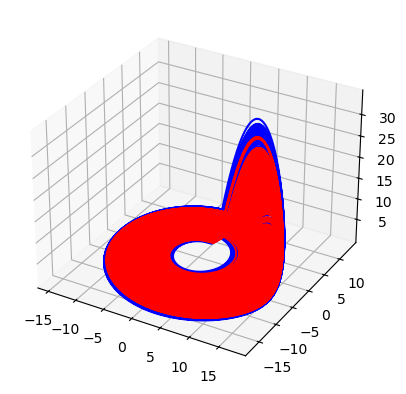

In [315]:
#trajectoryの左3列をx1, y1, z1, 右3列をx2, y2, z2としてそれぞれプロット(projection="3d")
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot(trajectory[:,0], trajectory[:,1], trajectory[:,2], color="blue")
ax.plot(trajectory[:,3], trajectory[:,4], trajectory[:,5], color="red")
plt.show()

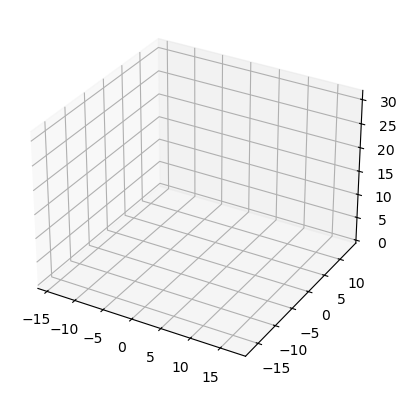

In [316]:
# 3Dアニメーション
fig = plt.figure()
ims = []
ax = fig.add_subplot(111, projection="3d")  
for i in range(t_steps // 10000):
    im = ax.plot(trajectory[:1000 * i, 0], trajectory[:1000 * i, 1], trajectory[:1000 * i, 2], color="blue")
    im += ax.plot(trajectory[:1000 * i, 3], trajectory[:1000 * i, 4], trajectory[:1000 * i, 5], color="red")
    # im = plt.plot(trajectory[:1000 * i, 0], trajectory[:1000 * i, 1], color="blue")
    # im += plt.plot(trajectory[:1000 * i, 3], trajectory[:1000 * i, 4], color="red")
    ims.append(im)
ani = ArtistAnimation(fig, ims)
ani.save("coupled_rossler.mp4", writer="ffmpeg")
HTML(ani.to_jshtml())


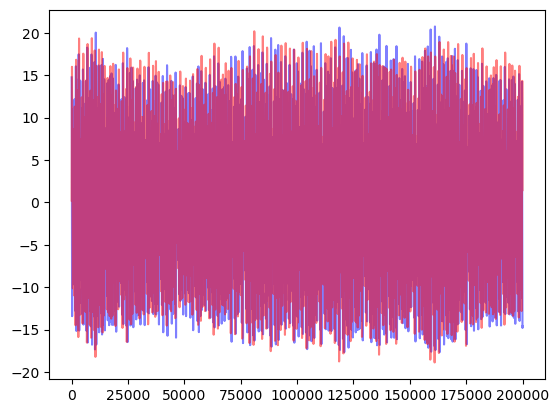

In [317]:
plt.plot(trajectory[:,0]-trajectory[:,3], color="blue", alpha=0.5)
plt.plot(trajectory[:,1]-trajectory[:,4], color="red", alpha=0.5)

# plt.ylim(-0.5, 0.5)

# 位相

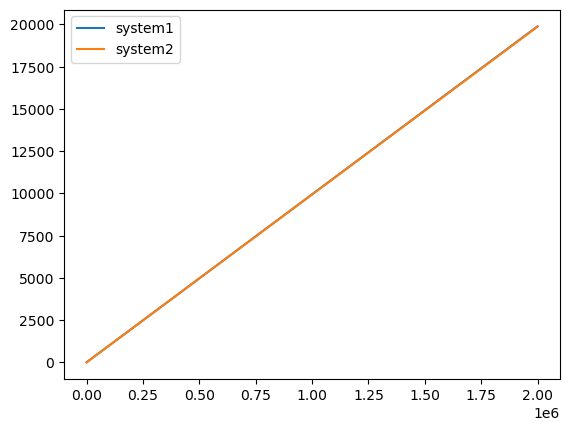

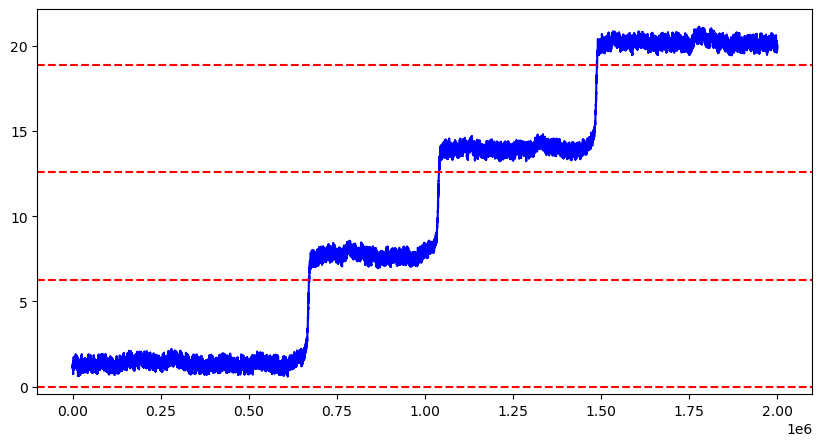

In [328]:
phase1 = angle(trajectory[:,0], trajectory[:,1])
#アンラップ
phase1 = np.unwrap(phase1)

phase2 = angle(trajectory[:,3], trajectory[:,4])
#アンラップ
phase2 = np.unwrap(phase2)

#2つの位相をプロット
plt.figure()
plt.plot(phase1, label="system1")
plt.plot(phase2, label="system2")
plt.legend()
plt.show()

#位相差を計算
phase_diff = (phase1 - phase2)
index = np.arange(len(phase_diff))
#phase_diffの最大値 > 2kπとなるような最大のkを求める
n = max(phase_diff) // (2 * np.pi)

plt.figure(figsize=(10,5))
# plt.plot((trajectory[:,0]-trajectory[:,3])/10, color="blue", alpha=0.5)
# plt.scatter(index, phase_diff, s=0.01)
plt.plot(phase_diff, color="blue")
for i in range(int(n) + 1):
    plt.axhline(y=(2 * np.pi * i), color="red", linestyle="--")


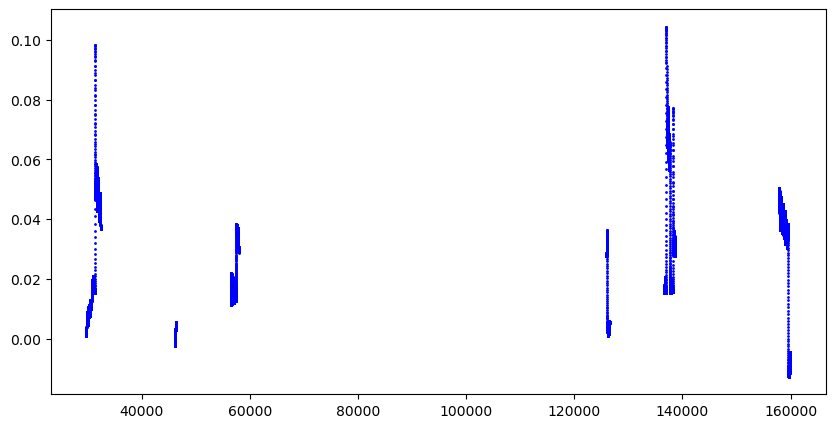

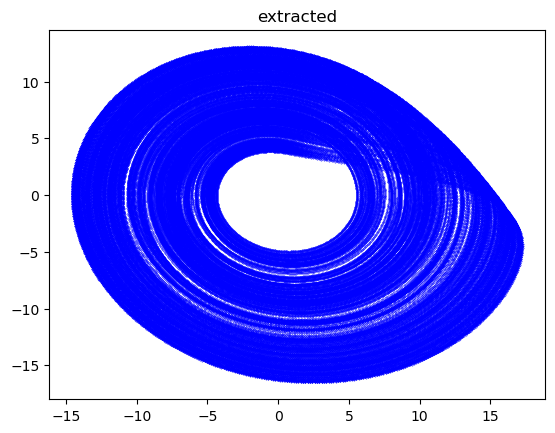

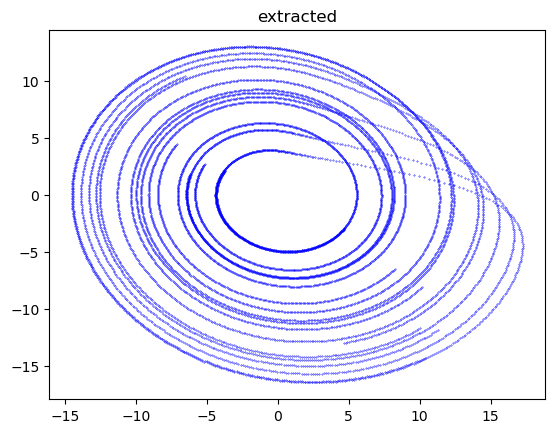

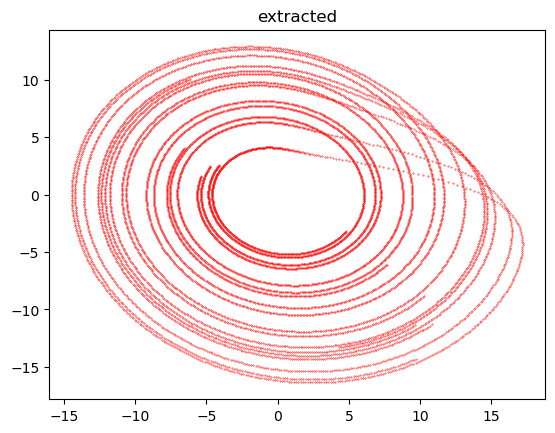

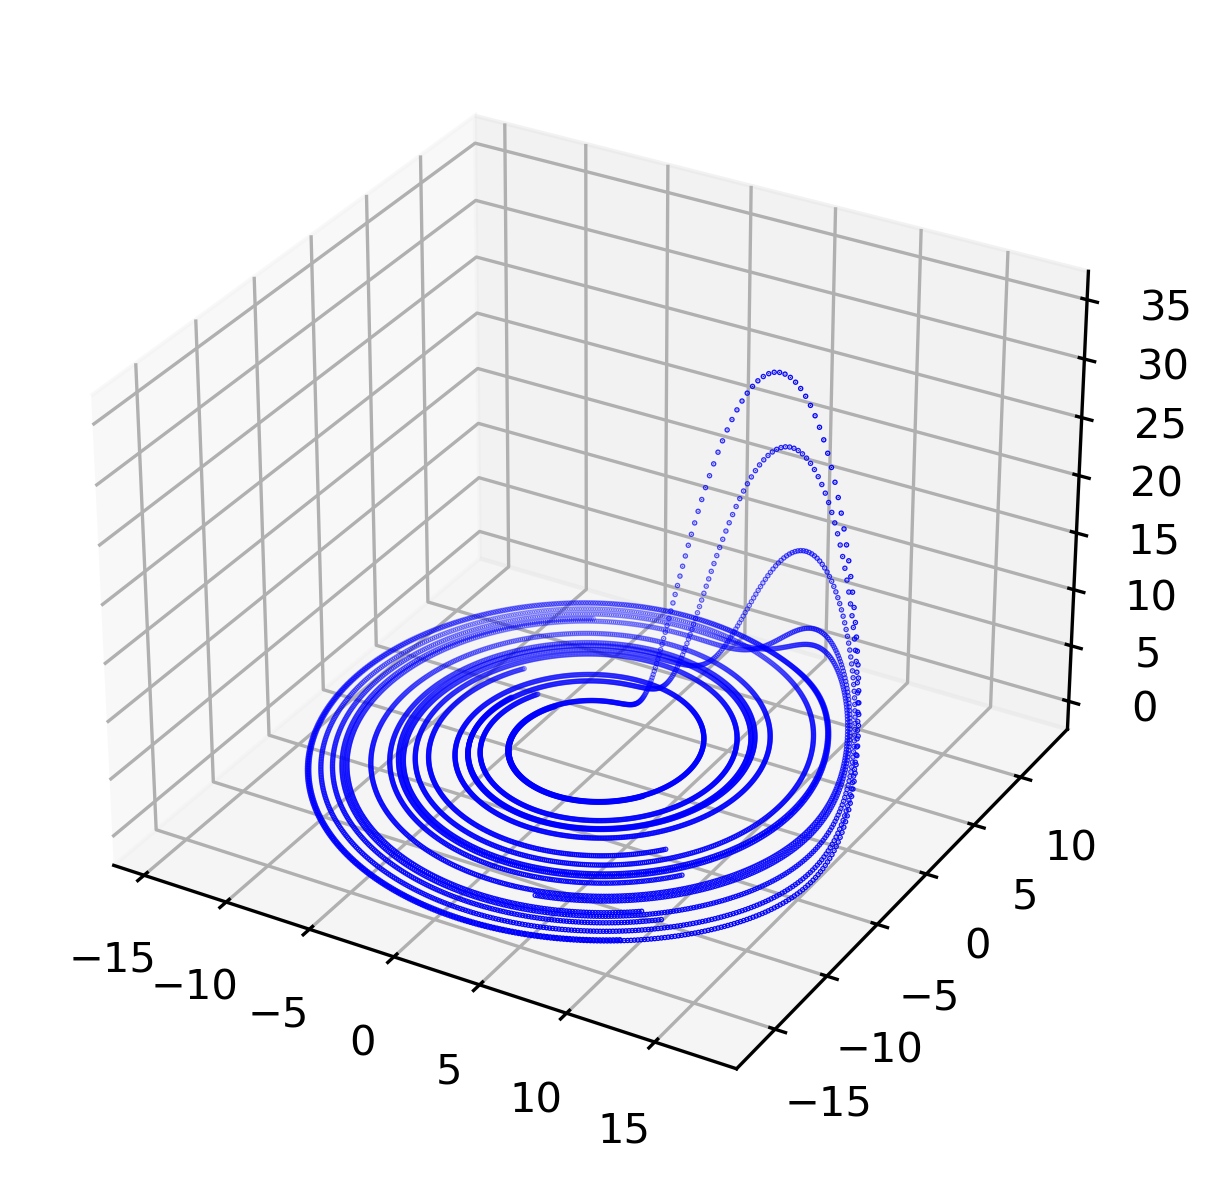

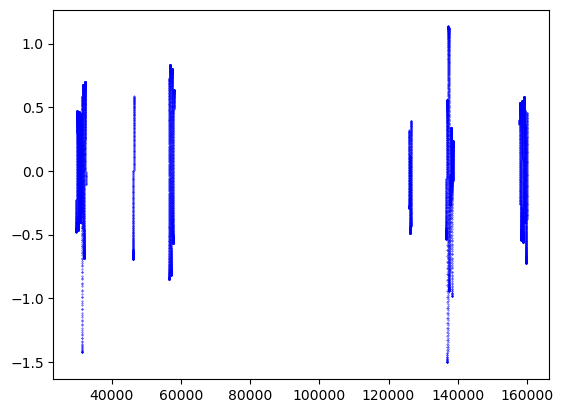

In [277]:
eqs = 0.15
window = 100
window*=100
#phase_diffがeqsより小さいところにwindow個以上連続しているところを抽出
extracted_ind = index[abs(phase_diff) < eqs]
#extracted_indのうち、window個以上数字が連続しているところを抽出
trimmed_ind = []
counter = 0
for i in range(len(extracted_ind) - 1):
    if extracted_ind[i+1] > extracted_ind[i]+1:
        if counter > window:
            trimmed_ind.extend(extracted_ind[i-counter+window//2:i-window//2])
        counter = 0
    else:
        counter += 1
if counter > window:
    trimmed_ind.extend(extracted_ind[i-counter+window//2:i-window//2])
extracted = trajectory[trimmed_ind, :]
extracted_phase_diff = phase_diff[trimmed_ind]
plt.figure(figsize=(10,5))
plt.scatter(trimmed_ind, extracted_phase_diff, color="blue", s=1)
plt.figure()
plt.title("extracted")
plt.scatter(trajectory[:,0], trajectory[:,1], color="blue", s=0.1)
plt.figure()
plt.title("extracted")
plt.scatter(extracted[:,0], extracted[:,1], color="blue", s=0.1)
plt.figure()
plt.title("extracted")
plt.scatter(extracted[:,3], extracted[:,4], color="red", s=0.1)

#3dプロット
fig = plt.figure(dpi=300)
ax = fig.add_subplot(111, projection="3d")
ax.scatter(extracted[:,0], extracted[:,1], extracted[:,2], color="blue", s=0.1)
plt.show()

plt.scatter(trimmed_ind, extracted[:, 0]-extracted[:, 3], color="blue", s=0.1)